# Simulation Experiments for 22T2 Reseach Proposal

In [1]:
import logging
import numpy as np
import pandas as pd
import pprint as pp
import gpboost as gpb
import tensorflow as tf
import bokeh.plotting as bop
import bokeh.models as bom
import statsmodels.api as sm

from sklearn.utils import check_random_state
from sklearn.datasets import make_friedman1, make_friedman3
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from simulate import make_sim4, make_sim5
from helper import split, evaluate_model, plot_from_model, plot_from_predictions, set_tf_loglevel, plot_loss_curves
from bokeh.io import output_notebook, export_svg
from tensorflow.keras import models, layers, optimizers, metrics
from tensorflow.random import set_seed
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from lmmnn.nn import calc_b_hat
from lmmnn.layers import NLL

In [2]:
output_notebook()

Loading BokehJS ...

## Experiment Set 1: Friedman1

In [3]:
# Experimental setup is adapted from Sigrist (2021) GPBoost paper
# Configure simulation parameters
n_train = 5000    # number of training observations
n = n_train * 2   # 5000 obs each for training and testing
m = 100           # number of groups
n_features = 8    # number of features
sigma2 = 1        # error variance
sigma2_b = 0.1    # variance parameter of random effects
random_seed = 42  # random seed for reproducibility
dist = "gamma"    # distribution of the response
scenario = "gamma"
group_dist = "skewed"
sim_structure = "friedman1"

# Generate data
# Doc: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html
# Out of the n_features features, only 5 are actually used to compute y. The remaining features are independent of y.
if (sim_structure == "friedman1"):
    X, F = make_friedman1(n_samples=n, n_features=n_features, random_state=random_seed)
elif (sim_structure == "friedman3"):
    X, F = make_friedman3(n_samples=n, random_state=random_seed)
    n_features = 4

# Simulate non-linear mean function
X = pd.DataFrame(X, columns=["X" + str(i) for i in range(1, n_features + 1)])
rng = check_random_state(42)
if (group_dist == "balanced"):
    X = X.assign(
        group = rng.randint(low=1, high=m + 1, size=n)
    )
elif (group_dist == "skewed"):
    X = X.assign(
        group = np.ceil(rng.beta(2, 3, size=n) * m).astype(int)
    )
b = np.sqrt(sigma2_b) * rng.standard_normal(size=m)
Zb = b[X.group - 1]

if (dist == "gaussian"):
    F_X = F / F[:100].std() * np.sqrt(sigma2_b) # marginal mean, or fixed effects mean, as in Sigrist we standardise this value st Var(F_X) = Var(b) = 1
    noise = np.sqrt(sigma2) * rng.standard_normal(size=n)
    truth = F_X + Zb
    y = truth + noise
    log_plot = False
    nn_loss = "mse"
elif (dist == "gamma"):
    F_X = F / F[:100].std() * np.sqrt(sigma2_b)
    truth = np.exp(F_X + Zb + 1)
    y = rng.gamma(truth, scale=np.sqrt(sigma2))
    log_plot = True
    nn_loss = "mean_squared_logarithmic_error" # not the best choice, but should be better than mse

In [4]:
# Train, test split
X_train, X_test, y_train, y_test = split(X, y, n_train)
# Conditional mean - true values (unobserved in practice)
y_true_train = pd.Series(truth[:n_train])
y_true_test = pd.Series(truth[n_train:])

X_train.to_csv(f"data/sim_{sim_structure}_X_train.csv", index=False)
X_test.to_csv(f"data/sim_{sim_structure}_X_test.csv", index=False)
pd.Series(y_train).to_csv(f"data/sim_{sim_structure}_y_train.csv", index=False)
pd.Series(y_test).to_csv(f"data/sim_{sim_structure}_y_test.csv", index=False)
y_true_train.to_csv(f"data/sim_{sim_structure}_y_true_train.csv", index=False)
y_true_test.to_csv(f"data/sim_{sim_structure}_y_true_test.csv", index=False)

### One-Hot Encoding

In [5]:
hicard_var = ["group"]
x_num = [col for col in X.columns if col not in hicard_var]
encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), hicard_var),
    (MinMaxScaler(feature_range=(0, 1)), x_num),
)
pipeline = make_pipeline(encoder, RandomForestRegressor(n_estimators=100, n_jobs=-1))

In [6]:
# Apply the pipeline to the dataframe for prediction
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['group']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8'])])),
                ('randomforestregressor', RandomForestRegressor(n_jobs=-1))])

In [7]:
print("> Training performance")
train_scores = evaluate_model(pipeline, X_train, y_train)
pp.pprint(train_scores)

print("-" * 80)
print("> Test performance")
test_scores = evaluate_model(pipeline, X_test, y_test)
pp.pprint(test_scores)

> Training performance
{'MAE': 0.9666681648892843, 'MSE': 1.5725684958896506, 'R2': 0.9106858002923222}
--------------------------------------------------------------------------------
> Test performance
{'MAE': 2.601366888796293, 'MSE': 11.411252050320396, 'R2': 0.3835969568322889}


In [8]:
p = plot_from_model(pipeline, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

### Ignore

In [9]:
ignore_cat_encoder = make_column_transformer(
    ("drop", hicard_var),
    (MinMaxScaler(feature_range=(0, 1)), x_num),
)
ignore_cat_pipeline = make_pipeline(ignore_cat_encoder, RandomForestRegressor(n_estimators=100, n_jobs=-1))
# Apply the pipeline to the dataframe for prediction
ignore_cat_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['group']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8'])])),
                ('randomforestregressor', RandomForestRegressor(n_jobs=-1))])

In [10]:
print("> Training performance")
train_scores = evaluate_model(ignore_cat_pipeline, X_train, y_train)
pp.pprint(train_scores)

print("-" * 80)
print("> Test performance")
test_scores = evaluate_model(ignore_cat_pipeline, X_test, y_test)
pp.pprint(test_scores)

> Training performance
{'MAE': 1.0826814869905026, 'MSE': 1.9662619328837434, 'R2': 0.8883259384820422}
--------------------------------------------------------------------------------
> Test performance
{'MAE': 2.9527339992438475, 'MSE': 14.55200719868699, 'R2': 0.2139423893263972}


In [11]:
plot_from_model(ignore_cat_pipeline, X_train, y_true_train, X_test, y_true_test, log_scale=log_plot)

Column(id='1382', ...)

### NN with Entity Embeddings

In [12]:
NUM_GROUPS = m

# Need to ordinal encode the categoricals first
# Note: here this is indeed not required as "group" is already an integer column, but we will do it anyways for completeness
encoder_nn = make_column_transformer(
    (MinMaxScaler(feature_range=(0, 1)), x_num),
    (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), hicard_var),
)

# Apply the column transformer to the training and testing sets
encoder_nn.fit(X_train)
X_train_scaled = pd.DataFrame(encoder_nn.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(encoder_nn.transform(X_test), columns=X_test.columns)

# Split the group variable apart from the rest
X_train_group = X_train_scaled["group"].astype(int)
X_test_group = X_test_scaled["group"].astype(int)
X_train_rest = X_train_scaled.drop(columns=["group"])
X_test_rest = X_test_scaled.drop(columns=["group"])

In [13]:
# Build a baseline neural network model with embeddings
# Configure network architecture
hidden_units = [20, 10, 5]
hidden_activation = "relu"
output_activation = "linear"
random_seed = 42

# Define the model
set_seed(random_seed)
group = layers.Input(shape=(1,), name="Group")
otherInputs = layers.Input(shape=X_train_rest.shape[1], name="OtherInputs")

groupEE = layers.Embedding(input_dim=NUM_GROUPS, output_dim=2, name="GroupEE")(group)
groupEE = layers.Flatten(name="GroupEEFlatten")(groupEE)

inputs = layers.Concatenate(name="Combined")([groupEE, otherInputs])
features = inputs
for hidden_layer in range(len(hidden_units)):
    units = hidden_units[hidden_layer]
    features = layers.Dense(units=units, activation=hidden_activation, name=f"Hidden_{hidden_layer + 1}")(features)
outputs = layers.Dense(units=1, activation=output_activation, name="Output")(features)
model = models.Model(inputs=[group, otherInputs], outputs=outputs)

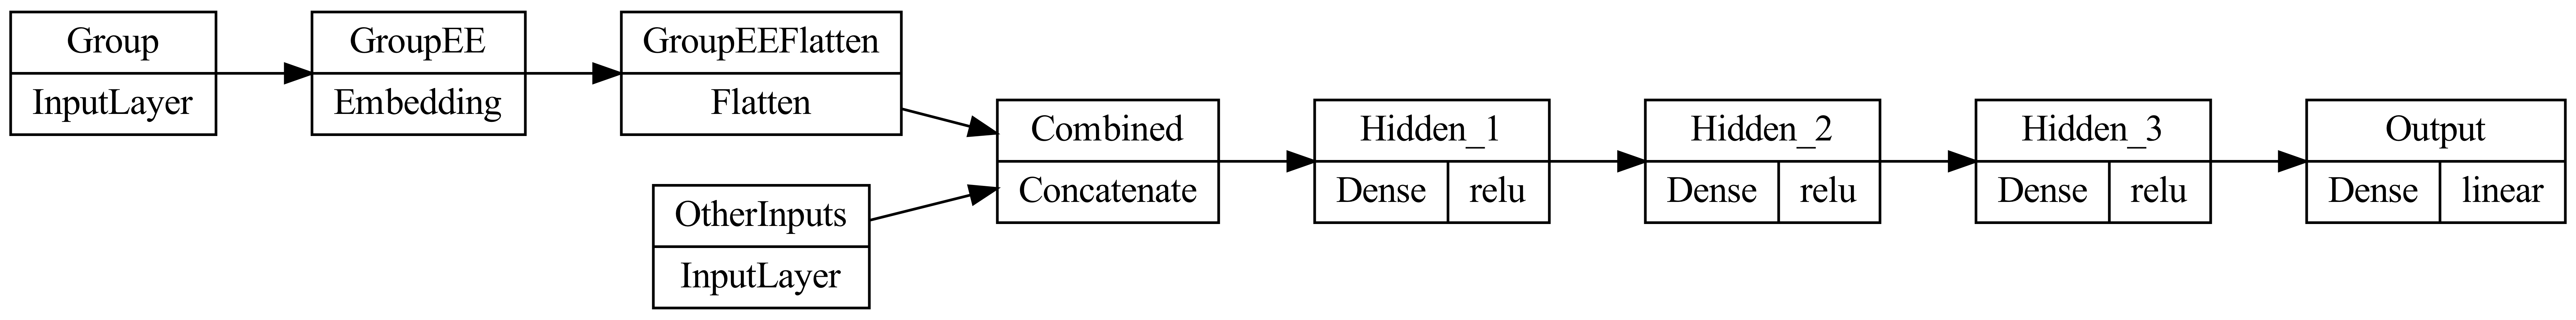

In [14]:
plot_model(model, dpi=600, show_layer_activations=True, rankdir="LR")

In [15]:
# Hi tensorflow, please stop printing INFO messages
set_tf_loglevel(logging.FATAL)

In [16]:
# Configure fitting parameters
learning_rate = 0.01
num_epochs = 500
batch_size = 128

# Fit the keras model
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss=nn_loss,
    metrics=["mae", "mse"]
)
es = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    (X_train_group, X_train_rest), y_train, 
    epochs=num_epochs, batch_size=batch_size, verbose=0, 
    validation_split=0.2, callbacks=[es])

# Return model performance
metrics = model.metrics_names
train_loss = dict(zip([f"train_{m}" for m in metrics], model.evaluate((X_train_group, X_train_rest), y_train, verbose=0)))
print(f"Training loss: {train_loss}")

test_loss = dict(zip([f"test_{m}" for m in metrics], model.evaluate((X_test_group, X_test_rest), y_test, verbose=0)))
print(f"Test loss: {test_loss}")

2022-06-28 22:37:51.002511: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Training loss: {'train_loss': 0.11979271471500397, 'train_mae': 2.154550313949585, 'train_mse': 8.363425254821777}
Test loss: {'test_loss': 0.13597941398620605, 'test_mae': 2.2479803562164307, 'test_mse': 9.172983169555664}


In [17]:
plot_from_predictions(
    y_pred_train=model.predict((X_train_group, X_train_rest)).flatten(),
    y_train = y_true_train,
    y_pred_test=model.predict((X_test_group, X_test_rest)).flatten(),
    y_test=y_true_test,
    log_scale=log_plot,
)

Column(id='1654', ...)

### Linear Mixed Effects Models

In [18]:
if (dist == "gaussian"):
    md = sm.MixedLM(y_train, X_train_scaled.drop(columns="group"), groups=X_train["group"])
elif (dist == "gamma"):
    # statsmodel doesn't yet support gamma GLMM, so we'll model log(y) i.e. assume lognormal distribution
    md = sm.MixedLM(np.log(y_train), X_train_scaled.drop(columns="group"), groups=X_train["group"])

mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y         
No. Observations: 5000    Method:             REML      
No. Groups:       97      Scale:              0.2064    
Min. group size:  1       Log-Likelihood:     -3402.9316
Max. group size:  104     Converged:          Yes       
Mean group size:  51.5                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
X1             0.473    0.023 20.519 0.000  0.428  0.518
X2             0.490    0.022 21.793 0.000  0.446  0.534
X3             0.021    0.023  0.917 0.359 -0.024  0.066
X4             0.673    0.023 29.707 0.000  0.629  0.718
X5             0.425    0.023 18.742 0.000  0.380  0.469
X6            -0.005    0.023 -0.208 0.835 -0.049  0.040
X7            -0.012    0.023 -0.533 0.594 -0.057  0.032
X8             0.006    0.022  0.273 0.78

In [19]:
# Evaluate model performance
# Training set
re = mdf.random_effects # BLUP coefficients
rev = [float(re[g]) for g in X_train["group"]]
# Add the fixed and random terms to get the overall prediction
if (dist == "gaussian"):
    fitted_values = mdf.predict() + rev
elif (dist == "gamma"):
    fitted_values = np.exp(mdf.predict() + rev)
print("> Training performance")
train_scores = {
    "MSE": mean_squared_error(y_train, fitted_values),
    "MAE": mean_absolute_error(y_train, fitted_values),
}
pp.pprint(train_scores)

# Test set
rev_test = [float(re[g]) for g in X_test["group"]]
if (dist == "gaussian"):
    predicted_values = mdf.predict(X_test_scaled.drop(columns="group")) + rev_test
elif (dist == "gamma"):
    predicted_values = np.exp(mdf.predict(X_test_scaled.drop(columns="group")) + rev_test)
print("> Test performance")
test_scores = {
    "MSE": mean_squared_error(y_test, predicted_values),
    "MAE": mean_absolute_error(y_test, predicted_values),
}
pp.pprint(test_scores)

> Training performance
{'MAE': 2.2630676650719828, 'MSE': 9.095547117738526}
> Test performance
{'MAE': 2.310123808055819, 'MSE': 9.66618779348076}


In [20]:
plot_from_predictions(fitted_values, y_true_train, predicted_values, y_true_test, log_scale=log_plot)

Column(id='1946', ...)

In [21]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
rev = np.array([float(re[g]) for g in X_train["group"]])
p.circle(Zb[:n_train], rev - rev.mean(), color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

### LMMNN
WARNING: Doesn't yet quite work for Gaussian so I won't attempt to do it for non-Gaussian distributions.

In [22]:
# Build an LMMNN model
# Configure network architecture
hidden_units = [20, 10, 5]
hidden_activation = "relu"
output_activation = "linear"
random_seed = 42
mode = "intercepts"
n_sig2bs = 1
est_cors = []

# Define the model
# Code adapted from: https://github.com/gsimchoni/lmmnn/blob/main/notebooks/neurips_single_categorical/airbnb.ipynb
set_seed(random_seed)
X_input = layers.Input(shape=X_train_rest.shape[1], name="FixedEffect")
Z_input = layers.Input(shape=(1,), name="RandomEffect", dtype=tf.int64)
y_input = layers.Input(shape=(1,), name="Response")

features = X_input
for hidden_layer in range(len(hidden_units)):
    units = hidden_units[hidden_layer]
    features = layers.Dense(units=units, activation=hidden_activation, name=f"Hidden_{hidden_layer + 1}")(features)
FE_output = layers.Dense(units=1, activation=output_activation, name="FEOutput")(features)

#TODO: How do we access the updated variance estimates??
nll = NLL(mode, 1.0, [1.0])(y_input, FE_output, [Z_input])
#TODO: This NLL layer implementation looks really weird, need to check underlying code
lmmnn = models.Model(inputs=[X_input, Z_input, y_input], outputs=nll)

In [23]:
# Configure fitting parameters
learning_rate = 0.01
num_epochs = 1000
batch_size = 128

# Fit the keras model
lmmnn.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=["mae", "mse"]
)
es = EarlyStopping(patience=100, restore_best_weights=True)
history = lmmnn.fit(
    (X_train_rest, X_train_group, y_train), None,
    epochs=num_epochs, batch_size=batch_size, verbose=0, 
    validation_split=0.2, callbacks=[es])

In [24]:
# Return model parameters
sig2e_est, sig2b_ests, *_ = lmmnn.layers[-1].get_vars()

# Evaluate model performance
# Note that I'm passing in a randomised version of y_train as a placeholder to the predict() method - not used in generating the predictions
# Training set
y_pred_tr = lmmnn.predict([X_train_rest, X_train_group, rng.standard_normal(size=y_train.shape)]).reshape(-1)
b_hat = calc_b_hat(
    X_train.rename(columns={"group": "z0"}), y_train, y_pred_tr, qs=[NUM_GROUPS], q_spatial=None, 
    sig2e=sig2e_est, sig2bs=sig2b_ests, sig2bs_spatial=None,
    Z_non_linear=False, model=lmmnn, ls=None, mode=mode, rhos=None, 
    est_cors=est_cors, dist_matrix=None, weibull_ests=None)
y_pred_tr += b_hat[X_train_group]
print("> Training performance")
train_scores = {
    "MSE": mean_squared_error(y_train, y_pred_tr),
    "MAE": mean_absolute_error(y_train, y_pred_tr),
}
pp.pprint(train_scores)

# Test set
y_pred_te = lmmnn.predict([X_test_rest, X_test_group, rng.standard_normal(size=y_test.shape)]).reshape(-1) + b_hat[X_test_group]
print("> Test performance")
test_scores = {
    "MSE": mean_squared_error(y_test, y_pred_te),
    "MAE": mean_absolute_error(y_test, y_pred_te),
}
pp.pprint(test_scores)

> Training performance
{'MAE': 117.50724086832055, 'MSE': 46818.534562785266}
> Test performance
{'MAE': 119.31064908206889, 'MSE': 63158.033848184394}


In [25]:
plot_from_predictions(y_pred_tr, y_true_train, y_pred_te, y_true_test, log_scale=log_plot)

Column(id='2438', ...)

In [26]:
plot_loss_curves(history)

In [27]:
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
p.circle(b, b_hat, color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)

### GPBoost
Installation seemed to work but I kept getting errors from any attempt to use a function from the package. The temporary workaround therefore is to use the R package and read in the predictions.

In [22]:
print("Please pause and run R script to generate the results required.")

Please pause and run R script to generate the results required.


In [23]:
y_pred_tr_gpb = pd.read_csv("results/GPBoost_friedman1_pred_tr.csv").values.reshape(-1)
y_pred_te_gpb = pd.read_csv("results/GPBoost_friedman1_pred_te.csv").values.reshape(-1)

In [24]:
print("> Training performance")
train_scores = {
    "MSE": mean_squared_error(y_train, y_pred_tr_gpb),
    "MAE": mean_absolute_error(y_train, y_pred_tr_gpb),
}
pp.pprint(train_scores)

print("> Test performance")
test_scores = {
    "MSE": mean_squared_error(y_test, y_pred_te_gpb),
    "MAE": mean_absolute_error(y_test, y_pred_te_gpb),
}
pp.pprint(test_scores)

> Training performance
{'MAE': 2.048822388689696, 'MSE': 7.165675780326854}
> Test performance
{'MAE': 2.267402352495934, 'MSE': 8.786975765505025}


In [25]:
plot_from_predictions(y_pred_tr_gpb, y_true_train, y_pred_te_gpb, y_true_test, log_scale=log_plot)

Column(id='2438', ...)

In [29]:
# Only works for Gaussian
p = bop.figure(title="Random Effects Predictions", x_axis_label="Ground truth", y_axis_label="Predictions", width=400, height=400)
rev = pd.read_csv("results/GPBoost_friedman1_pred_b.csv").values.reshape(-1)
p.circle(Zb[:n_train], rev - rev.mean(), color="#9f86c0")
p.add_layout(bom.Slope(gradient=1, y_intercept=0, line_color="black", line_width=2))
bop.show(p)